In [1]:
import sys
sys.path.append('..')

from scripts.GenrationGI0 import generate_multiple_images, mixed_dataset
from scripts.autoencoders import InMemoryImageDataset, ConfigurableAutoencoder
from scripts.measuring_quality import first_order_method, co_ocurrence_matrix, deltah, second_order_method

import torch
from torchvision import transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import cv2
from omegaconf import OmegaConf
import warnings
import matplotlib.pyplot as plt
import pandas as pd
from scipy.ndimage import uniform_filter
import random

In [2]:
try:
    OmegaConf.register_new_resolver("eval", eval)
except ValueError:
    pass

Elegir el archivo de configuración correspondiente:

In [3]:
config_name = 'config_simetrico-lr0_0005' # Elegir

config_path = f'configs/{config_name}.yaml'
config = OmegaConf.load(config_path)
config

{'training': {'n': 50000, 'n_cuad_lado': [2], 'pixeles_cuad': [25], 'ratio': [1], 'num_epochs': 500, 'batch_size': 64, 'learning_rate': 0.0005, 'scheduler_name': 'None', 'scheduler_params': 'None'}, 'model': {'encoding_dim': 32, 'loss_function': 'mse', 'optimizer': 'adam'}, 'encoder': {'layers': [{'type': 'conv2d', 'filters': 16, 'kernel_size': 3, 'stride': 2, 'padding': 1, 'activation': 'relu'}, {'type': 'flatten'}, {'type': 'dense', 'dim': '${model.encoding_dim}', 'activation': 'relu'}]}, 'decoder': {'layers': [{'type': 'dense', 'dim': 10000, 'activation': 'relu'}, {'type': 'unflatten', 'dim1': 25, 'dim2': 25, 'out_channels': 16}, {'type': 'conv2d_transpose', 'filters': 1, 'kernel_size': 2, 'stride': 2, 'padding': 0, 'activation': 'sigmoid'}]}, 'testing': {'n': 1000, 'batch_size': 32}}

In [4]:
assert len(config['training']['n_cuad_lado'])==1, 'Para simplificar las cosas, elegir un config que arme un dataset \
con un único tipo de partición de las imágenes.'

Genero dataset de testeo:

In [5]:
n = config['testing']['n']
batch_size = config['testing']['batch_size']
n_cuad_lado = config['training']['n_cuad_lado']
pixeles_cuad = config['training']['pixeles_cuad']

test_g, test_gi, test_gI0, alphas = mixed_dataset(
    n_total = n,
    generate_multiple_images = generate_multiple_images,
    conjunto_n_cuad_lado = n_cuad_lado,
    conjunto_pixeles_cuad = pixeles_cuad,
    ratios = config.training.get('ratio',[1]),
    save_alpha_values=True
)
del test_g

Normalizo:

In [6]:
test_gI0 = (test_gI0 - np.min(test_gI0, axis=(1, 2), keepdims=True)) / \
           (np.max(test_gI0, axis=(1, 2), keepdims=True) - np.min(test_gI0, axis=(1, 2), keepdims=True) + 1e-10)
test_gi = (test_gi - np.min(test_gi, axis=(1, 2), keepdims=True)) / \
          (np.max(test_gi, axis=(1, 2), keepdims=True) - np.min(test_gi, axis=(1, 2), keepdims=True) + 1e-10)

Voy a limpiar las imágenes ruidosas (test_gI0) usando el método de Lee. Cuanto más similares a las imágenes limpias (test_gi), mejor funcionó el filtro.

In [7]:
def lee_filter(image, window_size=3, noise_var=0.1):
    """
    Implementación del filtro de Lee para reducción de ruido en imágenes.
    
    Parameters
    ----------
        image: np.array
            Imagen de entrada.
        window_size: int
            Tamaño de la ventana, debe ser impar.
        noise_var: float
            Varianza estimada del ruido.
    
    Returns
    -------
        np.array
            Imagen filtrada.
    """
    if window_size % 2 == 0:
        raise ValueError("El tamaño de la ventana debe ser impar")
    
    # Calcula la media local usando un filtro uniforme
    mean_local = uniform_filter(image, size=window_size)
    
    # Calcula la varianza local
    sqr_local = uniform_filter(image**2, size=window_size)
    var_local = sqr_local - mean_local**2
    
    # Calcula los coeficientes del filtro de Lee
    k = 1 - (noise_var / np.maximum(var_local, noise_var))
    
    # Aplica el filtro
    filtered_image = mean_local + k * (image - mean_local)
    
    return filtered_image

El filtro de Lee necesita un valor para la varianza estimada del ruido. Lo calculo tomando la varianza en una zona homogénea de las imágenes, y promediando esa varianza sobre varias imágenes:

In [22]:
var = []
for i in range(test_gI0.shape[0]):
    if alphas[0][i][0,0] <= -6:
        var.append(np.var(test_gI0[i,0:pixeles_cuad[0],0:pixeles_cuad[0]]))
np.mean(var)

np.float64(0.0012429716835893224)

---
## Calidad del filtro de Lee
##### Calculo los estadísticos de primer y segundo orden para medir la calidad del filtro de Lee

Primero necesitamos los ratios de las de imágenes originales a las imágenes filtradas:

In [37]:
inputs = test_gI0
targets = test_gi

outputs = np.empty_like(test_gI0)
for i in range(test_gI0.shape[0]):
    outputs[i] = lee_filter(test_gI0[i], window_size=3, noise_var=np.mean(var))

ratios = inputs / outputs

Grafico solo a modo de ejemplo:

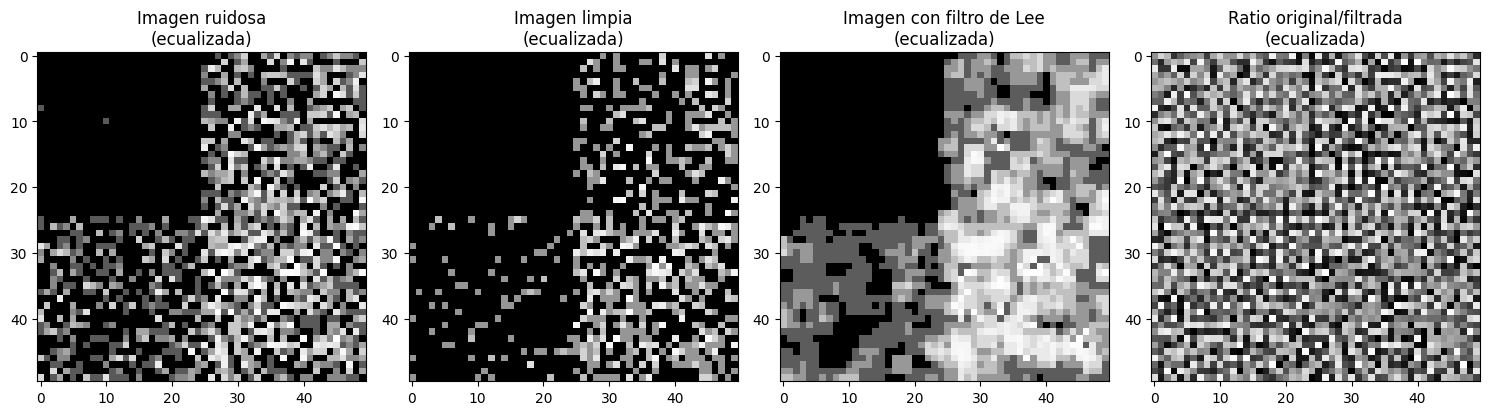

In [48]:
ecualizar_hist = True  # Si se quiere o no ecualizar el histograma de la imagen

###

def graph_random_image_with_ratios(inputs, targets, outputs, ratios, ecualizar_hist, show_plot=True):

    index = int(n*np.random.random()) # Índice del ejemplo puntual que se desea seleccionar
    entrada_red, target_red, salida_red, ratios = inputs[index, :, :], targets[index, :, :], outputs[index, :, :], ratios[index, :, :]

    imagenes = [entrada_red, target_red, salida_red, ratios]
    titulos = ['Imagen ruidosa', 'Imagen limpia', 'Imagen con filtro de Lee', 'Ratio original/filtrada']

    fig, axes = plt.subplots(1, 4, figsize=(15, 5))
    for ax, imagen, titulo in zip(axes, imagenes, titulos):
        if ecualizar_hist:
            imagen = ((imagen - imagen.min()) * 255) / (imagen.max() - imagen.min())
            imagen = cv2.equalizeHist(imagen.astype(np.uint8))
            titulo += '\n(ecualizada)'
        
        ax.imshow(imagen, cmap='gray')
        ax.set_title(titulo)

    plt.tight_layout()

graph_random_image_with_ratios(inputs, targets, outputs, ratios, ecualizar_hist)

### Estadístico de primer orden

### Estadístico de segundo orden